# Homework 2

In [1]:
import numpy as np
import cvxpy as cp

import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation, rc
plt.style.use('ggplot')

from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings('ignore')

## Problem 1: Factor Model Analysis and Optimization for Stock Returns (60 points)

Suppose we have $N$ stocks, for which, the log-returns at time $t$ is denoted by $\mathbf{x}_t\in \mathbb{R}^{N}$. Consider the following linear factor model

$$ \mathbf{x}_t = \boldsymbol{\alpha} + \boldsymbol{\beta} \mathbf{f}_t + \boldsymbol{\epsilon}_{t}, ~~ t = 1, 2, ..., T$$
where $\mathbf{f}_t \in \mathbb{R}^{2}$ denotes the values of the factors at time $t$, and $\boldsymbol{\alpha} \in \mathbb{R}^{N}$ and $\boldsymbol{\beta} \in \mathbb{R}^{N\times 2}$ are constant parameters.

In this excercise, we use the log-returns of 10 popular stocks as $\mathbf{x}_t$ starting from `2019-01-01` to `2022-12-31`. We also use the S&P500 index and the Bitcoin price within the same period, for the factors $\mathbf{f}_t$. The price data may be queried using the following code:

In [2]:
# Provided
stocks = ['TSLA', 'AMZN', 'EBAY', 'AAPL', 'MSFT', 'META', 'GOOGL', 'NFLX', 'IBM', 'NVDA']   
indices = ['^GSPC', 'BTC-USD']

prices = pdr.get_data_yahoo(stocks, start="2019-01-01", end="2022-12-31")[['Adj Close']]
factors = pdr.get_data_yahoo(indices, start="2019-01-01", end="2022-12-31")[['Adj Close']]

# Interpolate and fill missing values
data_merged = factors.join(prices)
data_merged = data_merged.interpolate()

prices = data_merged['Adj Close'][stocks].fillna(1)
factors = data_merged['Adj Close'][indices].fillna(1)

# Log returns
log_return_prices = prices.apply(np.log).apply(np.diff)
log_return_factors = factors.apply(np.log).apply(np.diff)

print(log_return_prices.head(), '\n')
print(log_return_factors.head())

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  2 of 2 completed
       TSLA      AMZN      EBAY      AAPL      MSFT      META     GOOGL   
0  3.028909  4.343240  3.291708  3.637441  4.568733  4.910299  3.965260  \
1 -0.031978 -0.025566 -0.018542 -0.104924 -0.037482 -0.029469 -0.028086   
2  0.056094  0.048851  0.022693  0.041803  0.045460  0.046061  0.050021   
3  0.017958  0.011386  0.005737 -0.000742  0.000425  0.000242 -0.000665   
4  0.017641  0.011258  0.005704 -0.000743  0.000425  0.000242 -0.000665   

       NFLX       IBM      NVDA  
0  5.589718  4.480576  3.520453  
1  0.013139 -0.020165 -0.062319  
2  0.092793  0.038314  0.062099  
3  0.019710  0.002355  0.017493  
4  0.019329  0.002350  0.017192   

      ^GSPC   BTC-USD
0  7.828050  0.025657
1 -0.025068 -0.027422
2  0.033759  0.005452
3  0.002334 -0.003251
4  0.002329  0.058447


### (a)

Explain about the meaning of $\boldsymbol{\alpha}$, $\boldsymbol{\beta}$, $\mathbf{f}_t$, and $\boldsymbol{\epsilon}_{t}$.

### Answer:

$\alpha_i$ is the part of the log-price of the $i$-th stock $\mathbf{x}_{t, i}$ which is not explained by the factor $\mathbf{f}_t$.

The coefficients $\boldsymbol{\beta}_i$ measures the degree of variability of the $i$-th stock with respect the factor $\mathbf{f}_t$.


$\mathbf{f}_t$ is the linear combination of factors of the S&P500 index and the Bitcoin price on day $t$.

$\boldsymbol{\epsilon}_i$ donotes the risk associated with the $i$-th stock, which is the risks that cannot be explained by the factors.

### (b)

Find $\boldsymbol{\alpha}^*$ and $\boldsymbol{\beta}^*$ by solving the following least-squares problem using an optional solver in python (e.g., `CVXPY`):
$$ \{\boldsymbol{\alpha}^*, \boldsymbol{\beta}^*\} = \underset{\boldsymbol{\alpha},\boldsymbol{\beta}}{\text{argmin}}\quad \sum_{t=1}^T\|\mathbf{x}_t - \boldsymbol{\alpha} - \boldsymbol{\beta}\mathbf{f}_t\|^2 $$

_Note_: You may need to interpolate the data first to fill in the `NaN` entries.

In [3]:
# Least-squares problem
X = log_return_prices.to_numpy().T
f = log_return_factors.to_numpy().T
(N, T) = X.shape

alpha = cp.Variable((N, 1))
beta = cp.Variable((N, 2))
problem = cp.Problem(cp.Minimize(cp.sum_squares(X - alpha - beta @ f)))
problem.solve()

alpha = pd.DataFrame(alpha.value, columns = ["alpha"], index=stocks)
beta = pd.DataFrame(beta.value, columns = ["beta1", "beta2"], index=stocks)
print("alpha*:\n", alpha, '\n')
print(f"beta*:\n", beta)

alpha*:
           alpha
TSLA   0.000937
AMZN  -0.000170
EBAY   0.000125
AAPL   0.000629
MSFT   0.000382
META  -0.000340
GOOGL  0.000138
NFLX  -0.000206
IBM    0.000124
NVDA   0.000717 

beta*:
           beta1     beta2
TSLA   0.388590  0.163798
AMZN   0.555907  0.061970
EBAY   0.421532  0.035981
AAPL   0.466287  0.066690
MSFT   0.584870  0.061818
META   0.628715  0.067122
GOOGL  0.507886  0.059752
NFLX   0.714680  0.060979
IBM    0.573070  0.007982
NVDA   0.452343  0.140429


**(c)** Find $\mathbf{X}$ and $\mathbf{F}$, such that the above problem can be restated as follows

$$ \boldsymbol{\Gamma}^* = \underset{\boldsymbol{\Gamma}}{\text{argmin}}\, \|\mathbf{X} - \boldsymbol{\Gamma}\mathbf{F}\|_F^2 $$

where $\boldsymbol{\Gamma}=[\boldsymbol{\alpha} \quad \boldsymbol{\beta}] \in \mathbb{R}^{N \times 3}$.

### Answer:
$\mathbf{X} \in \mathbb{R}^{N \times T}$ represents the log-returns of the stocks.

$\mathbf{F}=\left[\mathbf{1}, \mathbf{f}^{\top}\right]^{\top} \in \mathbb{R}^{3 \times T}$ where $\mathbf{f} \in \mathbb{R}^{2 \times T}$ represents the factors log returns.

In [4]:
# Reformatted least-squares problem
Gamma = cp.Variable((N, 3))
F = np.vstack((np.ones((1,T)), f))

problem = cp.Problem(cp.Minimize(cp.sum_squares(X - Gamma @ F)))
problem.solve()

Gamma = pd.DataFrame(Gamma.value, columns = ["alpha", "beta1","beta2"], index=stocks)
print("Gamma*:\n", Gamma)

Gamma*:
           alpha     beta1     beta2
TSLA   0.000937  0.388590  0.163798
AMZN  -0.000170  0.555907  0.061970
EBAY   0.000125  0.421532  0.035981
AAPL   0.000629  0.466287  0.066690
MSFT   0.000382  0.584870  0.061818
META  -0.000340  0.628715  0.067122
GOOGL  0.000138  0.507886  0.059752
NFLX  -0.000206  0.714680  0.060979
IBM    0.000124  0.573070  0.007982
NVDA   0.000717  0.452343  0.140429


### (d)

Find the optimal values $\boldsymbol{\alpha}^*$ and $\boldsymbol{\beta}^*$ using the closed-form solution to the problem above (given in the [`Py-session_iid_modeling`](https://canvas.ust.hk/courses/48602/files/7262367?wrap=1&fd_cookie_set=1) slides) and compare with the previous part.

### Answer:
$$\boldsymbol{\Gamma}^*=\underset{\boldsymbol{\Gamma}}{\operatorname{argmin}}\|\mathbf{X}-\boldsymbol{\Gamma} \mathbf{F}\|_F^2=\mathbf{X F}^{\top}\left(\mathbf{F F}^{\top}\right)^{-1}$$

In [5]:
# Equivalent to F @ F.T * Gamma.T = F @ X.T
# Transposes are used to match dimensions
Gamma = np.linalg.solve( F@F.T, F@X.T).T
    
Gamma = pd.DataFrame(Gamma, columns = ["alpha", "beta1","beta2"], index=stocks)
print("Gamma*:\n", Gamma, '\n')

error = np.linalg.norm(X - Gamma @ F, 'fro')
print("Closed-form solution error : ", error)

Gamma*:
           alpha     beta1     beta2
TSLA   0.000937  0.388590  0.163798
AMZN  -0.000170  0.555907  0.061970
EBAY   0.000125  0.421532  0.035981
AAPL   0.000629  0.466287  0.066690
MSFT   0.000382  0.584870  0.061818
META  -0.000340  0.628715  0.067122
GOOGL  0.000138  0.507886  0.059752
NFLX  -0.000206  0.714680  0.060979
IBM    0.000124  0.573070  0.007982
NVDA   0.000717  0.452343  0.140429 

Closed-form solution error :  2.0855238408229093


### (e)
Draw a 3D scatter plot of points where the x-axis is $\boldsymbol{\beta}_1$ (first column of $\boldsymbol{\beta}$), the y-axis is $\boldsymbol{\beta}_2$ (second column of $\boldsymbol{\beta}$) and the z-axis is $\boldsymbol{\alpha}$.

_Hint_: You may use [matplotlib](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html) for this purpose. You can also use the function `ax.text()` to add labels to the points (stocks).

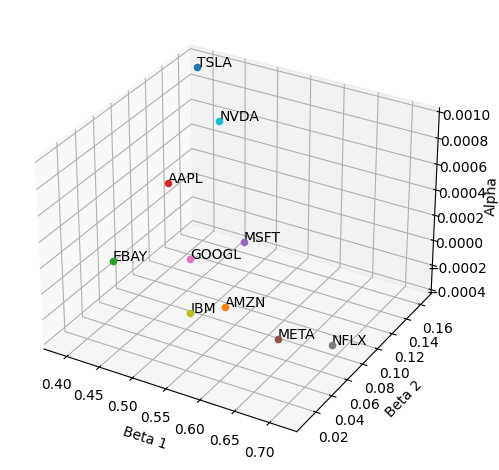

In [6]:
# 3D plot
plt.rcParams.update(plt.rcParamsDefault)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for stock in stocks:
    ax.scatter(Gamma.loc[stock, 'beta1'], Gamma.loc[stock, 'beta2'], Gamma.loc[stock, 'alpha'])
    ax.text(Gamma.loc[stock, 'beta1'], Gamma.loc[stock, 'beta2'], Gamma.loc[stock, 'alpha'], stock)
ax.set_xlabel('Beta 1')
ax.set_ylabel('Beta 2')
ax.set_zlabel('Alpha')
fig.tight_layout()
plt.show()

# Animation
#rc('animation', html='jshtml')
#def animate(frame):
    #ax.view_init(30, frame/2)
    #plt.pause(.001)
    #return fig
#anim = animation.FuncAnimation(fig, animate, frames=250, interval=10)
#anim

### (f)

Based on the previous plot and the meaning of $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$, which stocks are less risky to invest on and why?

### Answer:

The stocks with higher $\alpha$ and lower $\beta$ s would be less riskier to invest on. Hene, according to the above figure, stocks like 'TSLA', 'NVDA' and 'AAPL' have high $\alpha$ s while also having small $\beta_1$ s and $\beta_2 \mathrm{~s}$, and it would probably be less riskier to invest on them.

### (g) (Bonus)
Consider the statistical factor model where the factors $\mathbf{f}_t$ are not available. Assume the number of factors $K=2$. Write a piece of code to estimate the factors $\mathbf{f}_t$ and the values of $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$. Compare these parameters with those in part (b). Which method do you think works better and why?

_Hint_: Implement the algorithm given in the [`Py-session_iid_modeling`](https://canvas.ust.hk/courses/48602/files/7262367?wrap=1&fd_cookie_set=1) lecture slides under the heading `Statistical factor model`.

In [7]:
# Statistical factor model
K = 2
alpha = np.mean(X, axis=1)
X_sc = scale(X, with_std=False)
Sigma_prev = np.zeros((N, N))
Psi = np.zeros((N, N))
Sigma = np.cov(X_sc) 
while (np.linalg.norm(Sigma - Sigma_prev, 'fro') / np.linalg.norm(Sigma,'fro') > 1e-5):
    values, vectors = np.linalg.eig(Sigma - Psi)
    B = vectors[:, :K] * np.sqrt(values[:K])
    Psi = np.diag(np.diag(Sigma - B @ B.T))
    Sigma_prev = Sigma
    Sigma = B @ B.T + Psi

Gamma = np.column_stack([alpha, B]).real
Gamma_temp = pd.DataFrame(Gamma, index=stocks, columns=[['alpha', 'beta_1', 'beta_2']])
print(Gamma_temp, '\n')

B_inv = vectors[:, :K].real * np.sqrt(1/values[:K].real)
f =  B_inv.T @ (X - alpha.reshape((10,1))@ np.ones((1,T)))
f_temp = pd.DataFrame(f.T, index=log_return_prices.index, columns=[['factor1','factor2']]) 
print(f_temp, '\n')

F = np.vstack((np.ones((1,T)), f))
error = np.linalg.norm(X - Gamma @ F, 'fro')
print("Statistical factor model error: ", error)

          alpha    beta_1    beta_2
TSLA   0.003299 -0.032702  0.017283
AMZN   0.003037  0.005952 -0.001156
EBAY   0.002545 -0.021744 -0.007146
AAPL   0.003334 -0.012664 -0.004277
MSFT   0.003753  0.010974 -0.002489
META   0.003283  0.021522 -0.000022
GOOGL  0.003071 -0.003681 -0.004312
NFLX   0.003898  0.040047  0.010670
IBM    0.003374  0.008851 -0.007652
NVDA   0.003416 -0.016556 -0.000899 

        factor1   factor2
0     36.250865  3.261286
1      0.703780  1.079669
2      0.401782  1.537158
3     -0.033673  0.751921
4     -0.033676  0.736339
...         ...       ...
1454   0.202980 -1.025026
1455   0.210901 -1.055341
1456  -0.487723  1.203250
1457  -0.307169  1.941733
1458   0.044998  0.707232

[1459 rows x 2 columns] 

Statistical factor model error:  13.244661348375951


The previous model had less approximation error. So it seemed to be a better way of describing the stock prices via the linear model.

## Problem 2: Portfolio Optimization and Sharpe Ratio Analysis Using Shrinkage Estimators (50 points)

The Sharpe ratio of a portfolio $\mathbf{w} \in \mathbb{R}^{N}$ is defined as the ratio of its expected return to its volatility.

$$ \textsf{S} = \dfrac{\mathbf{w}^\top \boldsymbol{\mu}}{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} $$

Consider the portfolio optimization method in Problem 1 in your previous homework and choose a value of $\beta$. We refer to this as the “designed portfolio”.

### (a)

Consider the log-returns data in [**Problem 1**](#id_1) for three stocks including ‘AAPL’, ‘MSFT’ and ‘GOOGL’. Divide this data into two parts, one from `"2019-01-01"` to `"2021-12-31"`, which we call the training data and the other from `"2022-01-01"` to `"2022-12-31"`, which we refer to as the “test” data. Using the training set, define the function to compute the Sharpe ratio for the designed portfolio as a function of $\rho_1$ and $\rho_2$ assuming

$$ \boldsymbol{\Sigma} = \rho_1 \boldsymbol{\hat{\Sigma}} + (1 - \rho_1)\, \textsf{Diag}(\boldsymbol{\hat{\Sigma}}) $$

$$ \boldsymbol{\mu} = \rho_2 \boldsymbol{\hat{\mu}} + (1 - \rho_2)\dfrac{{\mathbf{1}_N}^\top \boldsymbol{\hat{\mu}}}{N}\mathbf{1}_N $$

where $\hat{\boldsymbol{\Sigma}}$ is the sample covariance matrix and $\boldsymbol{\hat{\mu}}$ is the sample mean.

In [8]:
prices_train = prices.loc['2019-01-01':'2021-12-31', :][['AAPL','MSFT','GOOGL']]
prices_test = prices.loc['2022-01-01':'2022-12-31', :][['AAPL','MSFT','GOOGL']]

# Log return
log_returns_train = prices_train.apply(np.log).apply(np.diff)
log_returns_test = prices_test.apply(np.log).apply(np.diff)

print(log_returns_train.head(), '\n')
print(log_returns_test.head())

# Designed portfolio
def design_portfolio(mu, Sigma, beta=0.05):
    w = cp.Variable(len(mu))
    problem = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)),
                         [w @ mu >= beta, w >= 0, cp.sum(w) == 1])   
    problem.solve()
    return w.value

# Designed portfolio with shrinkage
def design_portfolio_shrinkage(rho_1, rho_2, mu_hat, Sigma_hat, beta=0.05):
    N = Sigma_hat.shape[0]
    mu = rho_2 * mu_hat + (1 - rho_2) * np.sum(mu_hat) * np.ones(N) / N
    Sigma = rho_1 * Sigma_hat + (1 - rho_1) * np.diag(np.diag(Sigma_hat))
    w  = design_portfolio(mu, Sigma, beta)
    sharpe_ratio = np.dot(mu, w) / np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    return w, sharpe_ratio

       AAPL      MSFT     GOOGL
0  3.637441  4.568733  3.965260
1 -0.104924 -0.037482 -0.028086
2  0.041803  0.045460  0.050021
3 -0.000742  0.000425 -0.000665
4 -0.000743  0.000425 -0.000665 

       AAPL      MSFT     GOOGL
0  0.008232 -0.001560  0.000321
1  0.008165 -0.001562  0.000321
2 -0.012773 -0.017296 -0.004091
3 -0.026960 -0.039144 -0.046962
4 -0.016834 -0.007933 -0.000200


### (b)

Use all possible pairs for $\rho_1$ and $\rho_2$ in $\{0, 0.2, 0.4, 0.6, 0.8, 1\}$ and plot a [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) of the Sharpe ratios. Find the pair $(\rho_1, \rho_2)$ that gives the highest Sharpe ratio (on the training data). (You may also plot this as an image via [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)).

Max Sharpe ratio: 0.0689704031553427
(rho_1, rho_2): (0.0, 0.0)


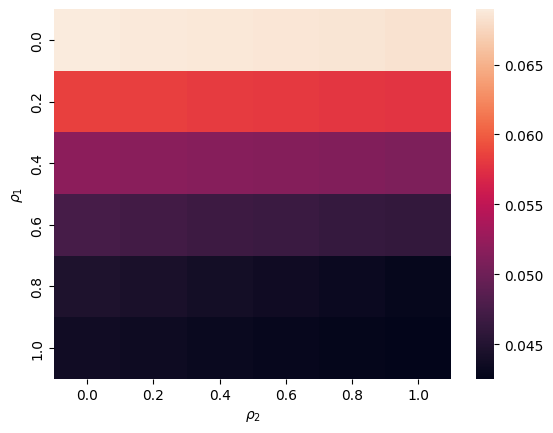

In [9]:
rho = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
mu_train = log_returns_train.mean()
Sigma_train = log_returns_train.cov()

# All possible combinations of rho_1 and rho_2
sharpe_ratios = []
portfolios = []
beta = 0.003    # Choose beta, some beta gives none w
for rho_1 in rho:
    for rho_2 in rho:
        w, sharpe_ratio = design_portfolio_shrinkage(rho_1, rho_2, mu_train, Sigma_train, beta)
        portfolios.append(w)
        sharpe_ratios.append(sharpe_ratio)
sharpe_ratios = np.array(sharpe_ratios).reshape(6,6)

# Max Sharpe ratio (rho_1, rho_2)
idx_max_sharpe_ratio = np.argmax(sharpe_ratios)
i, j = int(idx_max_sharpe_ratio / len(rho)), idx_max_sharpe_ratio % len(rho)
print(f"Max Sharpe ratio: {sharpe_ratios[i, j]}")
print(f"(rho_1, rho_2): ({rho[i]}, {rho[j]})")

# Heatmap
sns.heatmap(sharpe_ratios, xticklabels=rho, yticklabels=rho)
plt.xlabel(r'$\rho_2$')
plt.ylabel(r'$\rho_1$')
plt.show()

### (c)

With the pair found in part (b), compute the Sharpe ratio for the designed portfolio on the test data.

In [10]:
mu_test = log_returns_test.mean()
Sigma_test = log_returns_test.cov()

w = portfolios[idx_max_sharpe_ratio]
test_sharpe_ratio = np.dot(mu_test, w) / np.sqrt(np.dot(w.T, np.dot(Sigma_test, w)))
print("w: ", w)
print("Sharpe ratio: ", test_sharpe_ratio)

w:  [0.40197235 0.25739827 0.34062937]
Sharpe ratio:  -0.06143211776547214


### (d)

Compare the value of the test Sharpe ratio to the case where there is no shrinkage estimator used (For $(\rho_1, \rho_2) = (1, 1)$).

In [11]:
w = portfolios[-1]
test_sharpe_ratio_no_shrinkage = np.dot(mu_test, w) / np.sqrt(np.dot(w.T, np.dot(Sigma_test, w)))
print("w: ", w)
print("Sharpe ratio: ", test_sharpe_ratio_no_shrinkage)

w:  [1.00000000e+00 8.67210454e-25 4.77043528e-24]
Sharpe ratio:  -0.04901757318414666
